# Title

# Loan Default — Exploratory Data Analysis (EDA)

This notebook performs EDA on a loan-default style dataset with mixed numeric and categorical features, missing values, and potential outliers.

**Outputs**
- Initial inspection & schema snapshot
- Data quality (missingness, duplicates)
- Univariate visuals (numeric histograms, categorical bars)
- Correlation heatmap (numeric + target)
- Outlier check (IQR-based)
- Mutual Information (numeric → binary target, discretized)
- Auto-generated `EDA_Report.md` with embedded figure links


# Parameters

In [3]:
# ==== Parameters ====
TRAIN_CSV = "data/training_loan_data.csv"  # your training CSV (not committed)
TARGET    = "bad_flag"                      # binary target column
OUTPUT_DIR = "artifacts"                    # outputs
ID_COL    = None                            # optional id column
SKIPROWS  = 0                               # set to 1 if first file line is NOT a header

MAX_HISTS = 12    # max numeric histograms
MAX_CATS  = 12    # max categorical bar charts

# create output dirs
import os
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)


# Imports

In [15]:
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif


# Helpers

In [5]:
def numeric_and_categorical_columns(df: pd.DataFrame, target: str):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in num_cols:
        num_cols.remove(target)
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    # Heuristic: low-cardinality integers as categorical
    for c in list(num_cols):
        if pd.api.types.is_integer_dtype(df[c]) and df[c].nunique(dropna=True) <= 10:
            num_cols.remove(c); cat_cols.append(c)
    return num_cols, cat_cols

def plot_histogram(series: pd.Series, title: str, path: str):
    plt.figure()
    series.dropna().hist(bins=30)
    plt.title(title); plt.xlabel(series.name); plt.ylabel("frequency")
    plt.tight_layout(); plt.savefig(path); plt.close()

def plot_bar_top_counts(series: pd.Series, title: str, path: str, topn=20):
    plt.figure()
    series.astype(str).value_counts().head(topn).plot(kind="bar")
    plt.title(title); plt.xlabel(series.name); plt.ylabel("count")
    plt.tight_layout(); plt.savefig(path); plt.close()

def plot_corr_heatmap(df_num: pd.DataFrame, path: str, title="Correlation heatmap"):
    corr = df_num.corr(numeric_only=True)
    plt.figure(figsize=(min(12, 0.5 + 0.5*len(corr.columns)), min(10, 0.5 + 0.5*len(corr.columns))))
    im = plt.imshow(corr.values, aspect="auto")
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
    plt.yticks(range(corr.shape[0]), corr.index)
    plt.title(title); plt.colorbar(im)
    plt.tight_layout(); plt.savefig(path); plt.close()

def iqr_outlier_fractions(series: pd.Series):
    x = series.dropna().astype(float)
    if x.empty: return np.nan, np.nan, np.nan, np.nan
    q1, q3 = np.percentile(x, [25, 75]); iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    frac = ((x < lo) | (x > hi)).mean()
    return q1, q3, iqr, frac

def safe_mutual_info(X_num: pd.DataFrame, y: pd.Series):
    if X_num.empty: return pd.Series(dtype=float)
    kb = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    Xb = kb.fit_transform(X_num.fillna(X_num.median(numeric_only=True)))
    mi = mutual_info_classif(Xb, y, discrete_features=True, random_state=42)
    return pd.Series(mi, index=X_num.columns).sort_values(ascending=False)


# Load & initial inspection

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,desc,purpose,...,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,application_approved_flag,internal_score,bad_flag
0,20000001,22419852,10000,36 months,22.15%,8 years,RENT,37000.0,NaN,debt_consolidation,...,1,3.0,73.10%,16200,NaN,14877.170280,36809,1,131,NaN
1,20000002,22349118,1400,36 months,18.24%,6 years,RENT,41000.0,NaN,other,...,0,9.0,11.50%,4000,NaN,4097.304770,19536,1,19,NaN
2,20000003,22398818,7000,36 months,12.49%,3 years,RENT,68900.0,NaN,debt_consolidation,...,0,11.0,48.10%,11900,80.0,12688.495160,241465,1,92,NaN
3,20000004,22419015,18000,60 months,16.29%,9 years,MORTGAGE,41000.0,NaN,debt_consolidation,...,1,0.0,38.10%,7600,73.0,7908.799817,179757,1,235,NaN
4,20000005,22388614,12000,36 months,12.99%,10+ years,MORTGAGE,64000.0,NaN,home_improvement,...,0,NaN,57.90%,21000,NaN,19378.561060,31953,1,157,NaN


Shape: (102505, 23)


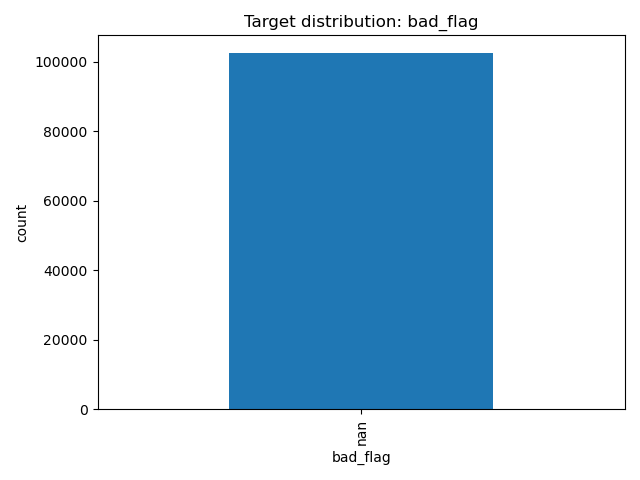

In [16]:
from IPython.display import Image, display

# Set your path and parameters
TRAIN_CSV = r"C:\Users\19452\Downloads\Take Home Project\Take Home Project\testing_loan_data.csv"
SKIPROWS = 0  # change to 1 if the first line is not a header
df = pd.read_csv(TRAIN_CSV, engine="python", skiprows=SKIPROWS)
assert TARGET in df.columns, f"Target '{TARGET}' not found. Columns: {df.columns.tolist()[:10]} ..."
n_rows, n_cols = df.shape
display(df.head())
print("Shape:", (n_rows, n_cols))

# Save schema snapshot
schema = {
    "shape": [int(n_rows), int(n_cols)],
    "columns": df.columns.tolist(),
    "dtypes": {c: str(dt) for c, dt in df.dtypes.items()},
    "head_sample": df.head(5).to_dict(orient="records"),
}
with open(f"{OUTPUT_DIR}/schema.json", "w") as f:
    json.dump(schema, f, indent=2)

# Target distribution
plt.figure()
df[TARGET].value_counts(dropna=False).sort_index().plot(kind="bar")
plt.title(f"Target distribution: {TARGET}")
plt.xlabel(TARGET); plt.ylabel("count")
plt.tight_layout(); plt.savefig(f"{FIG_DIR}/target_distribution.png"); plt.close()
display(Image(filename=f"{FIG_DIR}/target_distribution.png"))


# Data quality

In [22]:
# Missingness table (version-safe)
missing_frac = df.isna().mean().sort_values(ascending=False)
display(missing_frac.head(20))

mf = (
    missing_frac
      .to_frame(name="missing_fraction")  # Series -> DataFrame with column name
      .reset_index()                      # old/new pandas both support this
      .rename(columns={"index": "column"})  # name the index column
)
mf.to_csv(f"{OUTPUT_DIR}/missingness.csv", index=False)

# Duplicates
dup_cols = [c for c in df.columns if c != ID_COL] if ID_COL else df.columns.tolist()
n_dups = df[dup_cols].duplicated().sum()
print("Duplicate rows (excluding ID col if set):", n_dups)


bad_flag                       1.000000
desc                           0.851773
mths_since_last_major_derog    0.715663
mths_since_recent_inq          0.086123
emp_length                     0.051910
percent_bc_gt_75               0.010204
bc_util                        0.010165
revol_util                     0.000468
annual_inc                     0.000000
home_ownership                 0.000000
purpose                        0.000000
int_rate                       0.000000
member_id                      0.000000
dti                            0.000000
inq_last_6mths                 0.000000
term                           0.000000
total_bc_limit                 0.000000
loan_amnt                      0.000000
tot_hi_cred_lim                0.000000
tot_cur_bal                    0.000000
dtype: float64

Duplicate rows (excluding ID col if set): 0


# Feature typing

In [23]:
num_cols, cat_cols = numeric_and_categorical_columns(df, TARGET)
print("Numeric features:", len(num_cols)); print(num_cols[:25])
print("Categorical features:", len(cat_cols)); print(cat_cols[:25])


Numeric features: 13
['id', 'member_id', 'loan_amnt', 'annual_inc', 'percent_bc_gt_75', 'bc_util', 'dti', 'mths_since_recent_inq', 'total_bc_limit', 'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal', 'internal_score']
Categorical features: 9
['term', 'int_rate', 'emp_length', 'home_ownership', 'desc', 'purpose', 'revol_util', 'inq_last_6mths', 'application_approved_flag']


# Numeric distributions (sample)

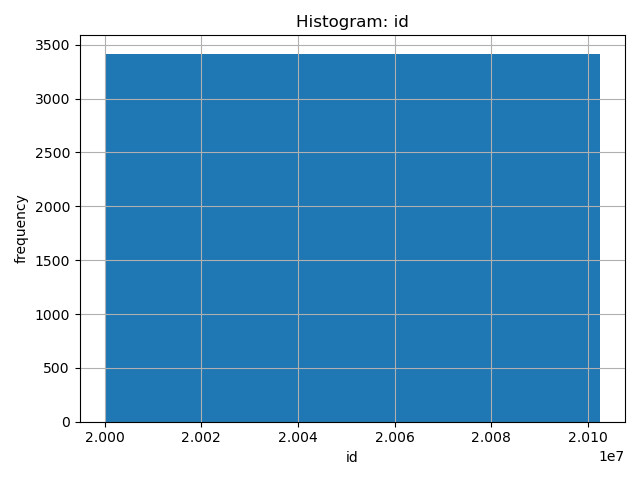

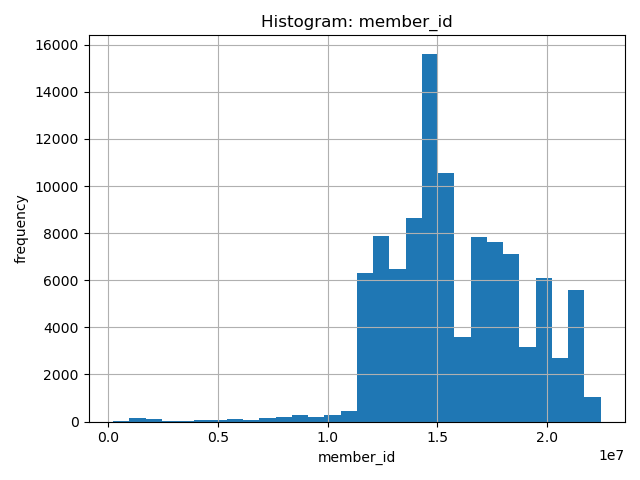

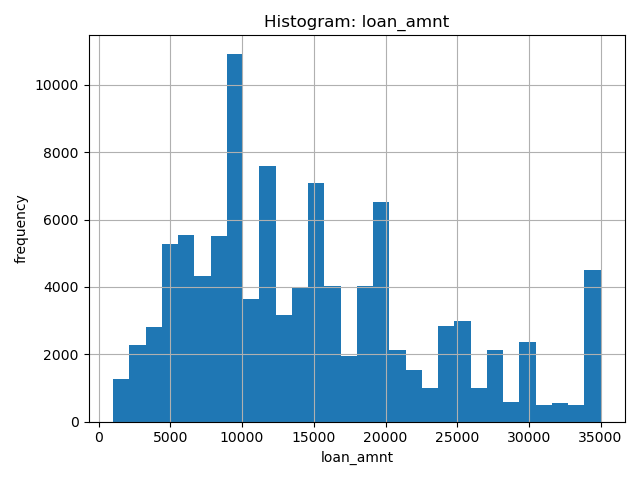

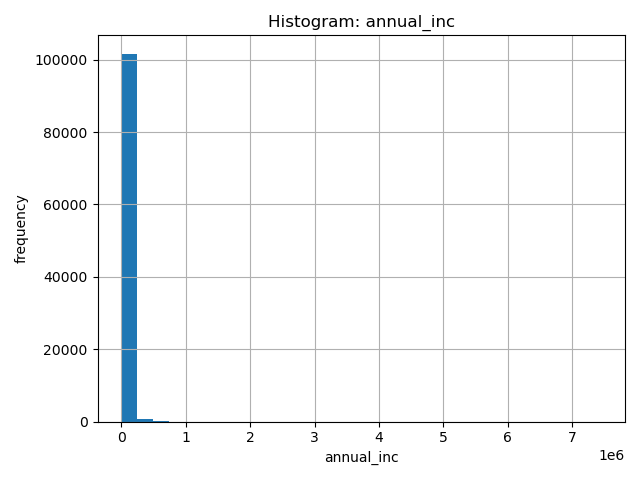

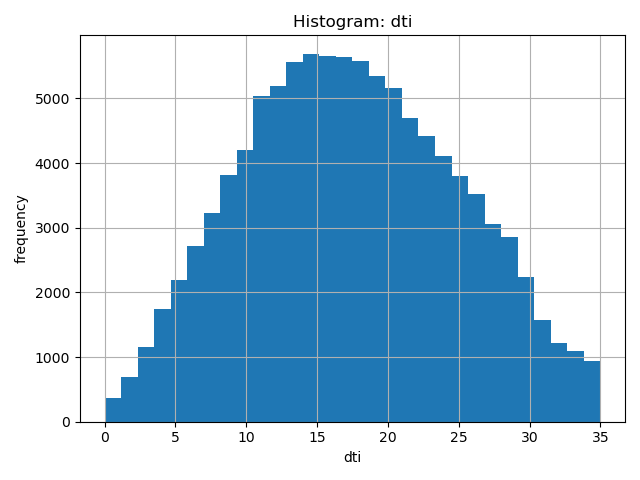

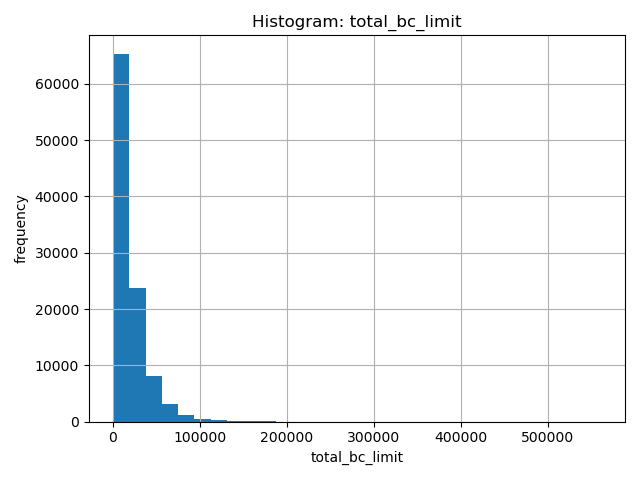

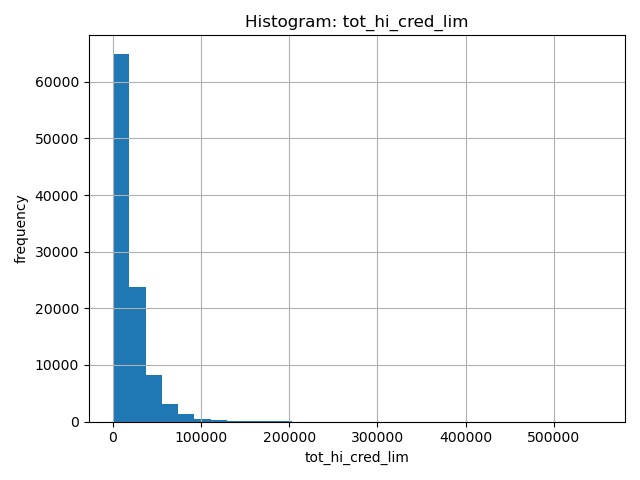

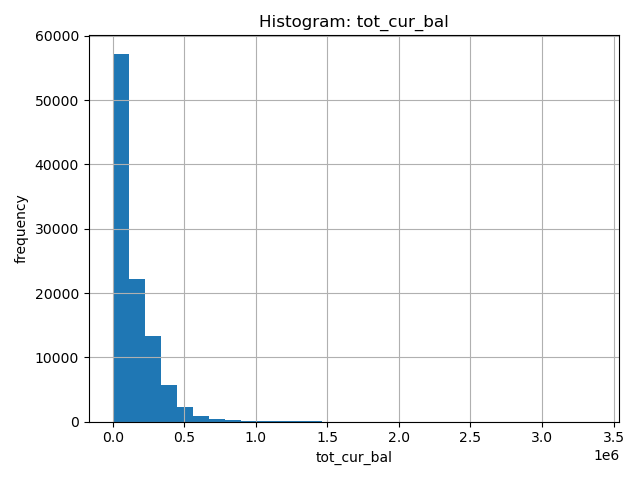

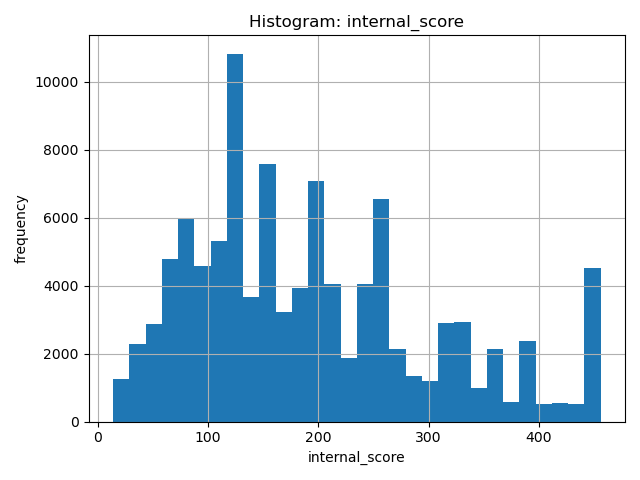

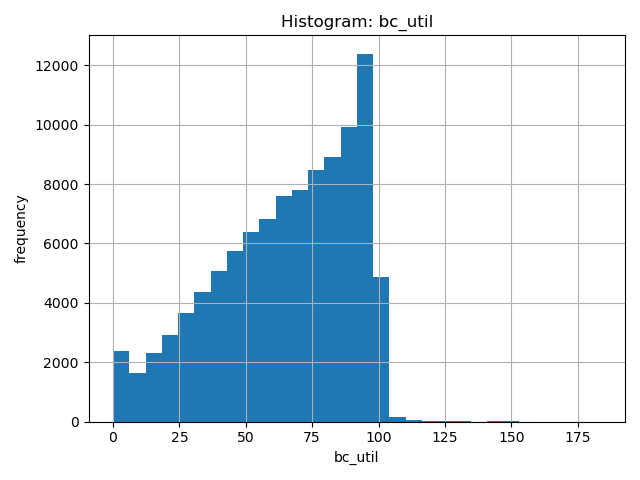

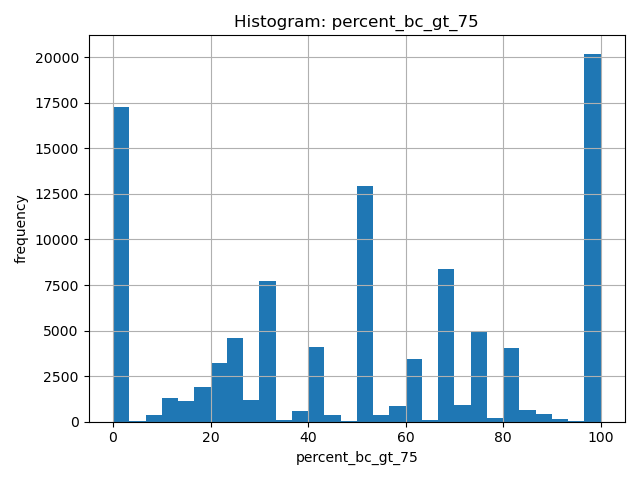

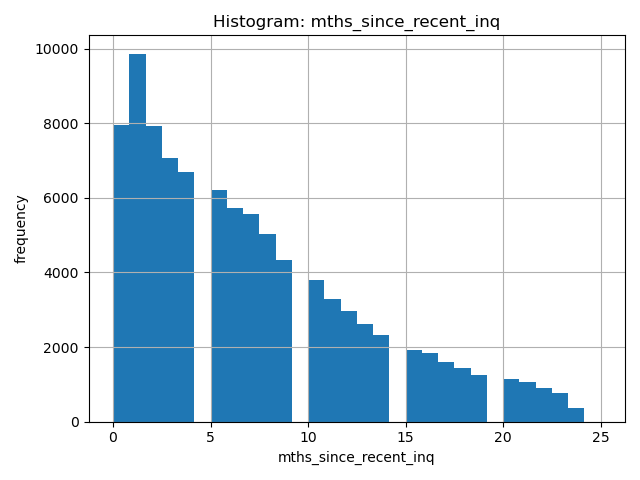

In [24]:
num_miss = df[num_cols].isna().mean().sort_values() if num_cols else pd.Series(dtype=float)
plot_num = num_miss.index[:min(MAX_HISTS, len(num_miss))].tolist()
for c in plot_num:
    plot_histogram(df[c], f"Histogram: {c}", f"{FIG_DIR}/hist_{c}.png")

for c in plot_num:
    display(Image(filename=f"{FIG_DIR}/hist_{c}.png"))


# Categorical frequencies (sample)

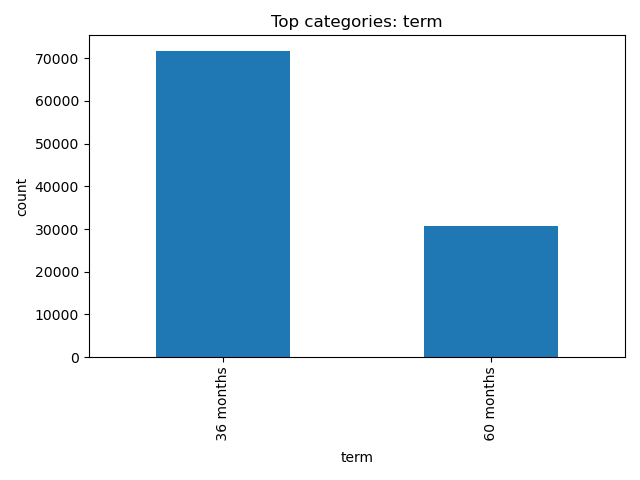

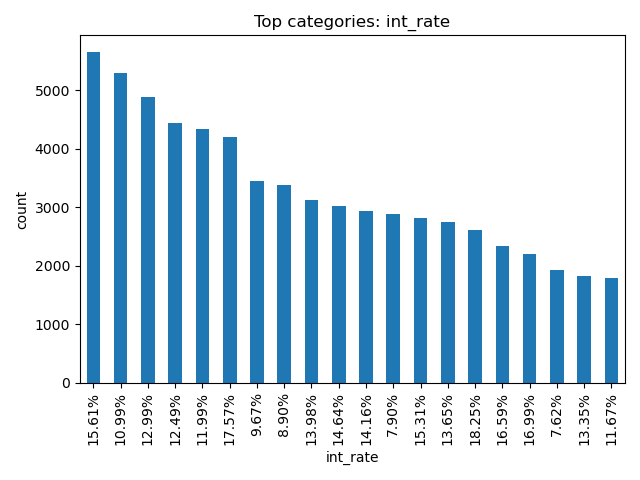

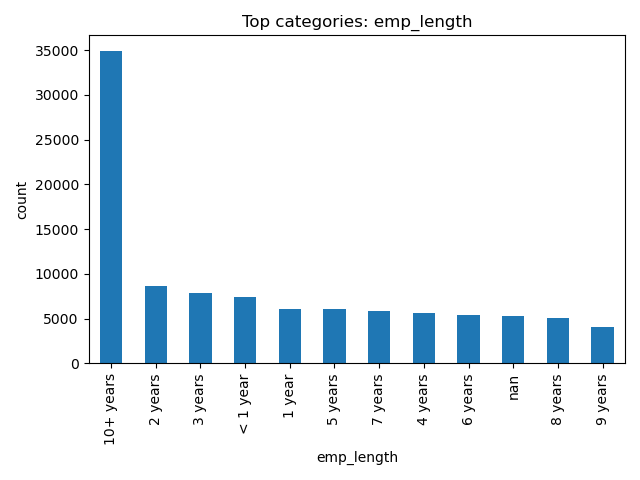

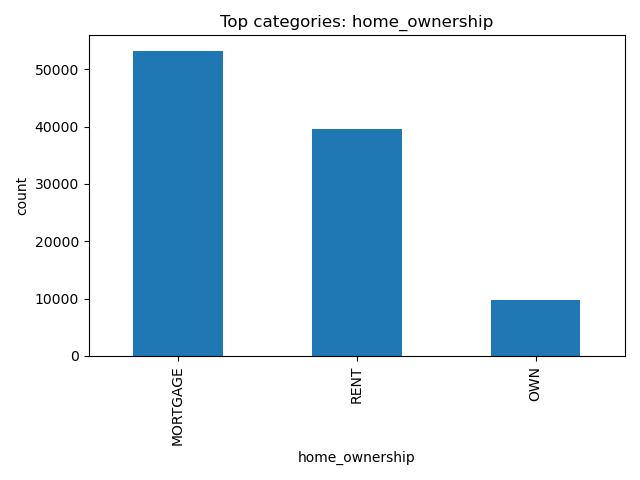

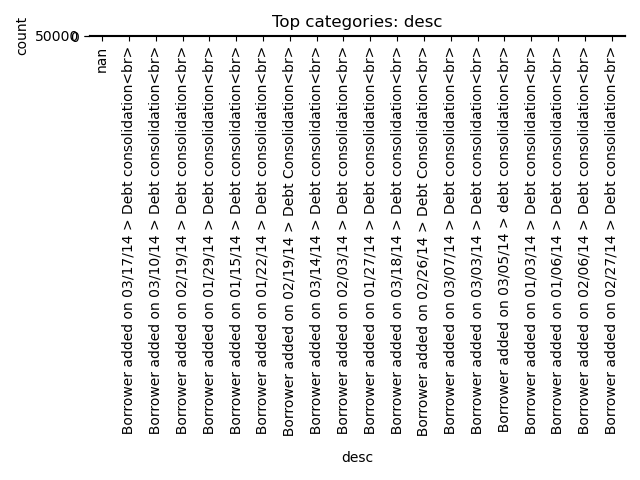

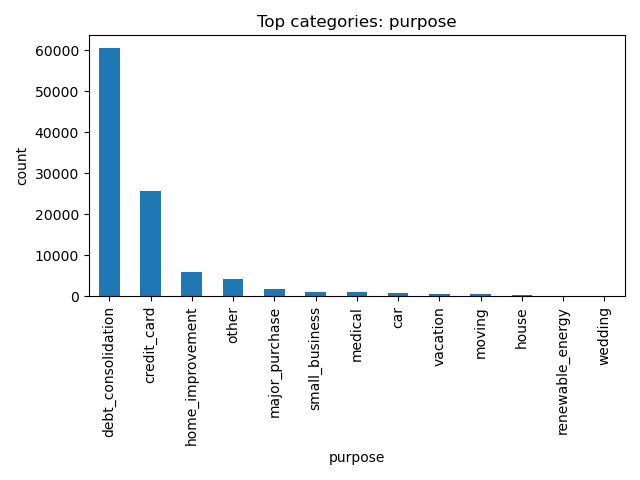

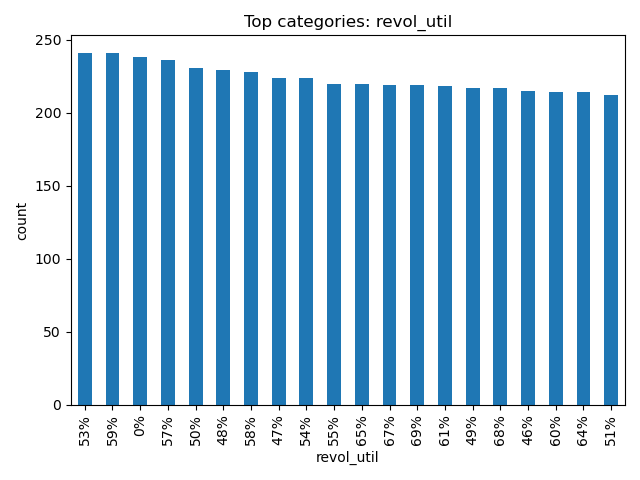

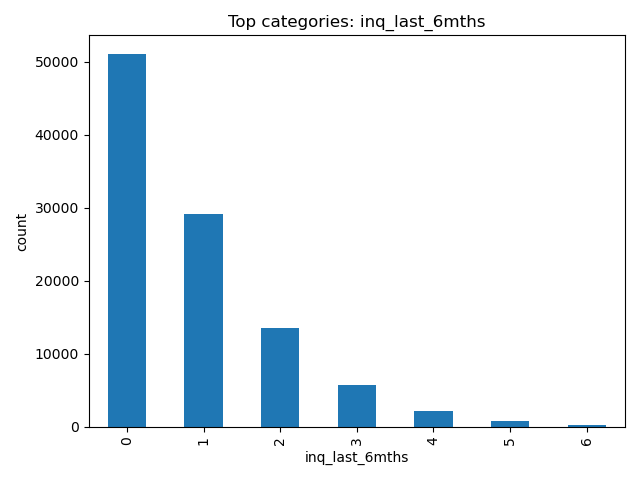

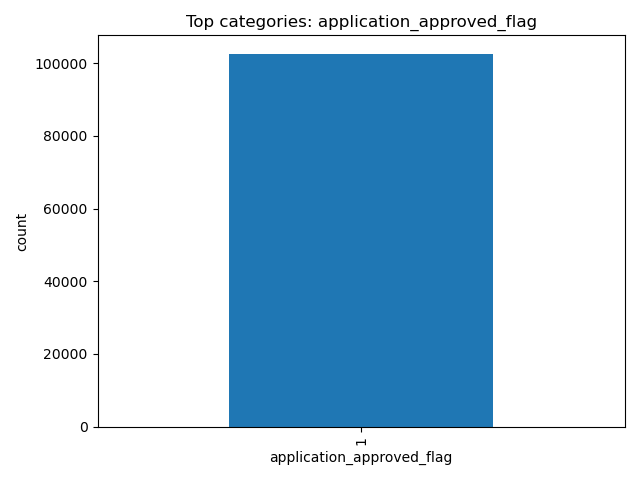

In [25]:
plot_cats = cat_cols[:min(MAX_CATS, len(cat_cols))]
for c in plot_cats:
    plot_bar_top_counts(df[c], f"Top categories: {c}", f"{FIG_DIR}/bar_{c}.png")

for c in plot_cats:
    display(Image(filename=f"{FIG_DIR}/bar_{c}.png"))


# Correlation heatmap (numeric + target if numeric)

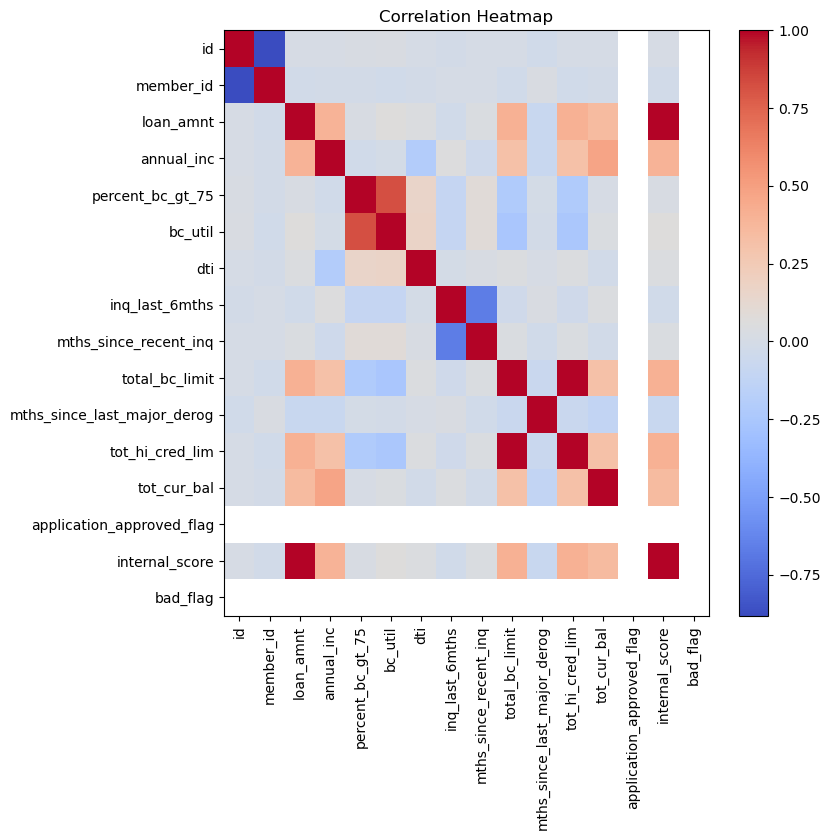

In [32]:
def plot_corr_heatmap(df_num: pd.DataFrame, path: str, title="Correlation heatmap"):
    # Keep only numeric columns
    df_num = df_num.select_dtypes(include=[np.number])
    if df_num.empty:
        print("No numeric columns for correlation.")
        return
    
    corr = df_num.corr()  # no numeric_only arg for older pandas
    plt.figure(figsize=(min(12, 0.5 + 0.5*len(corr.columns)), min(10, 0.5 + 0.5*len(corr.columns))))
    im = plt.imshow(corr.values, aspect="auto")
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
    plt.yticks(range(corr.shape[0]), corr.index)
    plt.title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(path)
    plt.close()

    # Force target to numeric if possible
if df[TARGET].dtype == object:
    try:
        df[TARGET] = pd.to_numeric(df[TARGET])
    except:
        pass

# Pick numeric columns, including target if numeric
num_cols_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()

if len(num_cols_for_corr) > 1:
    corr = df[num_cols_for_corr].corr()
    plt.figure(figsize=(0.5 + 0.5*len(corr.columns), 0.5 + 0.5*len(corr.columns)))
    im = plt.imshow(corr.values, aspect="auto", cmap="coolwarm")
    plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
    plt.yticks(range(corr.shape[0]), corr.index)
    plt.title("Correlation Heatmap")
    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/correlation_heatmap.png")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


# Outliers (IQR-based)

In [30]:
outlier_rows = []
for c in num_cols:
    q1, q3, iqr, frac = iqr_outlier_fractions(df[c])
    outlier_rows.append({"feature": c, "q1": q1, "q3": q3, "iqr": iqr, "outlier_fraction": frac})
outlier_df = pd.DataFrame(outlier_rows).sort_values("outlier_fraction", ascending=False)
display(outlier_df.head(20))
outlier_df.to_csv(f"{OUTPUT_DIR}/outliers_iqr.csv", index=False)


,feature,q1,q3,iqr,outlier_fraction
10,tot_hi_cred_lim,6.737412e+03,2.517553e+04,1.843812e+04,0.060787
8,total_bc_limit,6.800000e+03,2.520000e+04,1.840000e+04,0.060368
3,annual_inc,4.600000e+04,9.000000e+04,4.400000e+04,0.045051
11,tot_cur_bal,2.863500e+04,2.099410e+05,1.813060e+05,0.030642
1,member_id,1.366695e+07,1.806130e+07,4.394353e+06,0.006878
9,mths_since_last_major_derog,2.600000e+01,5.900000e+01,3.300000e+01,0.006588
5,bc_util,4.610000e+01,8.700000e+01,4.090000e+01,0.000039
7,mths_since_recent_inq,2.000000e+00,1.100000e+01,9.000000e+00,0.000021
0,id,2.002563e+07,2.007688e+07,5.125200e+04,0.000000
2,loan_amnt,8.400000e+03,2.000000e+04,1.160000e+04,0.000000


# Mutual Information (numeric → target)

In [33]:
# --- Mutual Information (numeric → target) --- #
from sklearn.feature_selection import mutual_info_classif

mi_series = pd.Series(dtype=float)

# 1) Coerce target to numeric and keep only 0/1 rows
y = pd.to_numeric(df[TARGET], errors="coerce")
mask_bin = y.isin([0, 1])
y_bin = y[mask_bin].astype(int)

# 2) Select numeric feature columns and align to mask
num_cols_clean = [c for c in num_cols if c in df.columns]  # safety
X_num = df.loc[mask_bin, num_cols_clean].apply(pd.to_numeric, errors="coerce")

# 3) Proceed only if we still have features
if len(num_cols_clean) > 0 and X_num.shape[0] > 1:
    # Fill NaNs with column medians before discretization/MI
    X_filled = X_num.fillna(X_num.median(numeric_only=True))

    # Discretize numeric features for MI
    from sklearn.preprocessing import KBinsDiscretizer
    kb = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    Xb = kb.fit_transform(X_filled)

    mi_vals = mutual_info_classif(Xb, y_bin, discrete_features=True, random_state=42)
    mi_series = pd.Series(mi_vals, index=num_cols_clean).sort_values(ascending=False)

    # Save (version-safe)
    mi_df = mi_series.to_frame(name="mutual_info").reset_index().rename(columns={"index": "feature"})
    mi_df.to_csv(f"{OUTPUT_DIR}/mutual_info_numeric.csv", index=False)

    display(mi_series.head(20))
else:
    print("No valid numeric features or insufficient rows with binary target; skipping MI.")


No valid numeric features or insufficient rows with binary target; skipping MI.


#  EDA_Report.md

In [36]:
lines = []
lines.append(f"# EDA Report — Loan Default\\n\\nGenerated: {datetime.now().isoformat(timespec='seconds')}\\n")
lines.append("## 1) Initial Inspection\\n")
lines.append(f"- Shape: **{df.shape}**\\n")
lines.append(f"- Target: **{TARGET}**\\n")
lines.append("- Head/sample saved to `schema.json`.\\n")
lines.append(f"![target](figures/target_distribution.png)\\n\\n")

lines.append("## 2) Data Quality\\n")
lines.append("- Per-column missingness saved to `missingness.csv`.\\n")
lines.append("- Duplicates count printed above.\\n")

lines.append("## 3) Feature Types\\n")
lines.append(f"- Numeric ({len(num_cols)}): {', '.join(num_cols[:25])}{'...' if len(num_cols)>25 else ''}\\n")
lines.append(f"- Categorical ({len(cat_cols)}): {', '.join(cat_cols[:25])}{'...' if len(cat_cols)>25 else ''}\\n")

if len(num_cols)>0:
    lines.append("## 4) Numeric Distributions (sample)\\n")
    for c in num_cols[:min(MAX_HISTS, len(num_cols))]:
        lines.append(f"**{c}**\\n\\n![{c}](figures/hist_{c}.png)\\n\\n")

if len(cat_cols)>0:
    lines.append("## 5) Categorical Frequencies (sample)\\n")
    for c in cat_cols[:min(MAX_CATS, len(cat_cols))]:
        lines.append(f"**{c}**\\n\\n![{c}](figures/bar_{c}.png)\\n\\n")

if len(num_cols)>0:
    lines.append("## 6) Correlations\\n")
    lines.append("See heatmap below.\\n\\n![corr](figures/correlation_heatmap.png)\\n\\n")

lines.append("## 7) Outliers (IQR)\\n- Saved to `outliers_iqr.csv`.\\n")
if (set(df[TARGET].dropna().unique()).issubset({0,1}) and len(num_cols)>0):
    lines.append("## 8) Mutual Information (numeric → target)\\n- Saved to `mutual_info_numeric.csv`.\\n")

lines.append("## 9) Insights (examples)\\n")
lines.append("- Class balance noted above; if skewed, use stratified split & threshold tuning.\\n")
lines.append("- Missingness concentrated in specific features—impute numerics with median, categoricals with most-frequent.\\n")
lines.append("- Some numerics show heavy tails; consider robust scaling or transforms.\\n")

import os

# Set output folder path (example: save in a subfolder called 'output' in the same directory as your notebook)
OUTPUT_DIR = "output"

# Create it if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

with open(f"{OUTPUT_DIR}/EDA_Report.md", "w", encoding="utf-8", newline="") as f:
    f.write("\n".join(lines))

print(f"Wrote {OUTPUT_DIR}/EDA_Report.md")


Wrote output/EDA_Report.md
